# Visualization Tools

We have included several visualizations that we have found useful through our development and use of the package. In this demo we will go through how to extend some of the ones we have already used through the webinar so that they can be adapted for more applications. It's worth noting that all of our plots are [matplotlib](https://matplotlib.org/)-compliant, so making changes or updates to the figures even after they are generated should be possible and easy to do.

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import numpy as np
import pandas as pd
from os import path
import MGSurvE as srv
import matplotlib.pyplot as plt
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('visualization', './out/')
srv.makeFolder(OUT_PTH)

## Plotting Trap Attractiveness Kernels

Plotting our traps attractiveness kernels involves generating a landscape and calling the `srv.plotTrapsKernels` method. Let's define three different traps:

In [2]:
# Defining a dummy landscape --------------------------------------------------
pts = pd.DataFrame({'x': [0, 1], 'y': [0, 1], 't': [0, 0]})
points = pd.DataFrame(pts, columns=('x', 'y', 't'))
# Traps info ------------------------------------------------------------------
nullPos = [0, 0, 0]
traps = pd.DataFrame({'x': nullPos, 'y': nullPos, 't': nullPos, 'f': nullPos})
tKer = {
    0: {
        'kernel': srv.exponentialAttractiveness,
        'params': {'A': 0.85, 'k': .01, 's': .3, 'gamma': .975, 'epsilon': 0}
    },
    1: {
        'kernel': srv.exponentialDecay, 
        'params': {'A': 0.5, 'b': 0.045}
    },
    2: {
        'kernel': srv.sigmoidDecay,     
        'params': {'A': 1, 'rate': .175, 'x0': 25}
    }
}
TCOL = {
    0: '#f7258515', 1: '#fe5f5515', 2: '#5ddeb125', 
    3: '#f038ff15', 4: '#e2ef7015', 5: '#9381ff15', 
}

And plot their profiles. Note that we are adding axis labels and changing the font sizes as we would do with any [matplotlib](https://matplotlib.org/) figure:

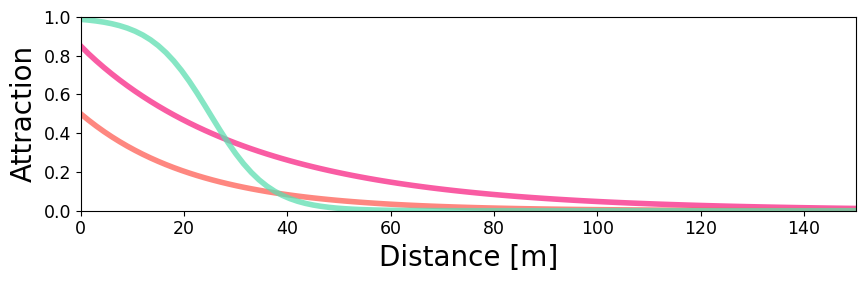

In [3]:
lnd = srv.Landscape(points, traps=traps, trapsKernels=tKer)
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
(fig, ax) = srv.plotTrapsKernels(
    fig, ax, lnd, 
    colors=TCOL, distRange=(0, 150), aspect=.25
)
ax.set_xlabel('Distance [m]', fontsize=20)
ax.set_ylabel('Attraction', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12.5)
fig.savefig(
    path.join(OUT_PTH, 'TrapKernels.png'), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

## Plotting Lanscapes

As we previously mentioned, our framework adheres to [matplotlib](https://matplotlib.org/) standards and, as such, we can add any type of compatible note or marker on our figures. In this example we will show some ways to do it.

### Euclidean

We will generate a random uniform landscape with 100 points and 3 traps in it:

In [4]:
PTS_NUM = 100
RADII = (-100, 100)
# Generate pointset -----------------------------------------------------------
xy = srv.ptsRandUniform(PTS_NUM, (RADII, RADII)).T
# Re-shape pointset into dataframe --------------------------------------------
points = pd.DataFrame({
    'x': xy[0], 'y': xy[1], 
    't': [0]*len(xy[0])
})
# Setup traps -----------------------------------------------------------------
nullTraps = [0, 0, 0]
traps = pd.DataFrame({
    'sid': nullTraps,
    'x': nullTraps, 'y': nullTraps,
    't': [0, 0, 1], 'f': nullTraps
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .1}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .125}}
}
# Instantiate Landscape -------------------------------------------------------
lnd = srv.Landscape(
    points, 
    kernelParams={'params': srv.MEDIUM_MOV_EXP_PARAMS, 'zeroInflation': .25}, 
    traps=traps, trapsKernels=tKer
)

Let's now add the ID numbers to the sites, so that we can move the traps manually:

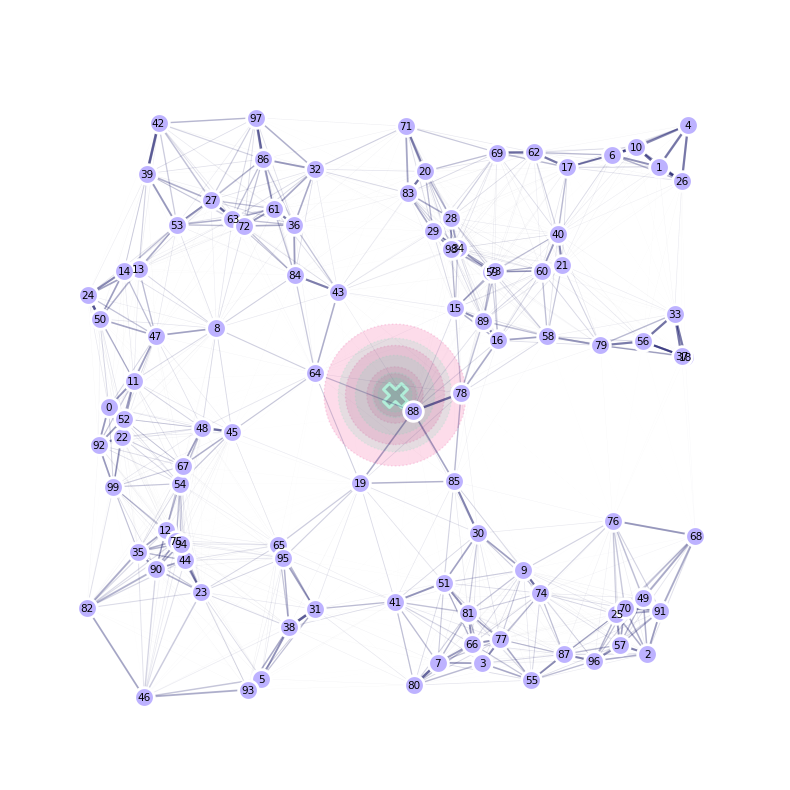

In [5]:
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax, transparencyHex='55', size=300, zorders=(-30,-30))
srv.plotClean(fig, ax, bbox=((-125, 125), (-125, 125)))
for (ix, xy) in enumerate(lnd.pointCoords):
    ax.text(
        xy[0], xy[1], int(ix), 
        fontsize=7.5, zorder=10, ha='center', va='center_baseline'
    )


Ok, now let's do something new. Let's position our traps in three sites of our choosing. This is done by calling:

In [6]:
trpSites = [25, 50, 75]
lnd.updateTrapsCoordsByID(trpSites)

Finally, let's calculate the current setup's fitness and plot our landscape again with the updated information!

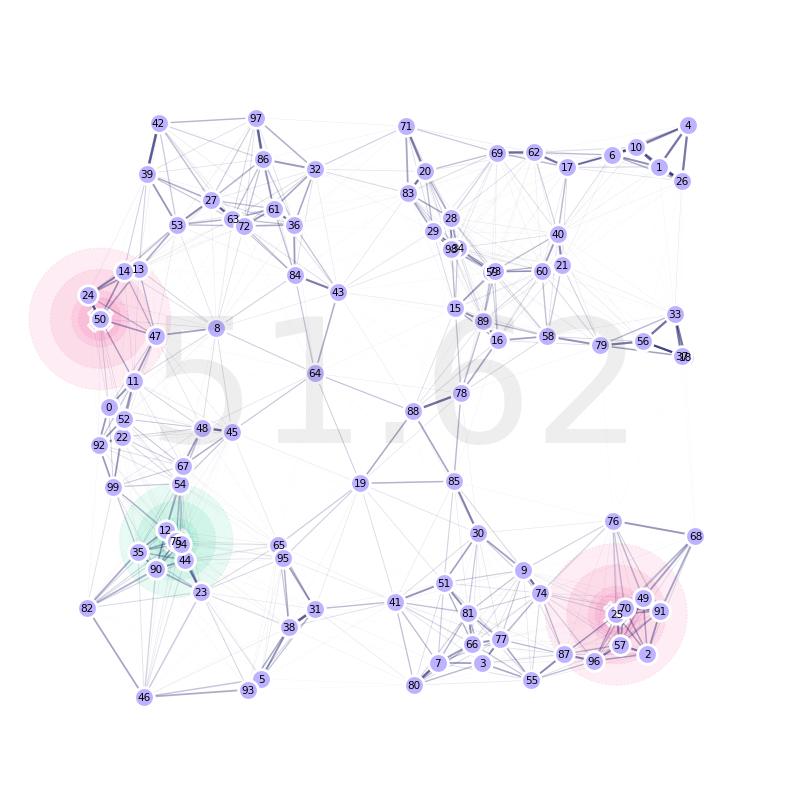

In [7]:
# Calculate the new fitness ---------------------------------------------------
fitness = srv.calcDiscreteFitness(
    lnd.trapsSiteID, lnd, 
    optimFunction=srv.getDaysTillTrapped,
    optimFunctionArgs={'inner': np.sum, 'outer': np.mean}
)[0]
# Plot the new location for the traps -----------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax, transparencyHex='55', size=300, zorders=(-20,-30))
srv.plotClean(fig, ax, bbox=((-125, 125), (-125, 125)))
srv.plotFitness(fig, ax, fitness)
for (ix, xy) in enumerate(lnd.pointCoords):
    ax.text(
        xy[0], xy[1], int(ix), 
        fontsize=7.5, zorder=10, ha='center', va='center_baseline'
    )

Alternatively, we could modify the coordinates of our traps directly and calculate the fitness in a continuous paradigm (using `calcFitness` instead of `calcDiscreteFitness`) as follows:

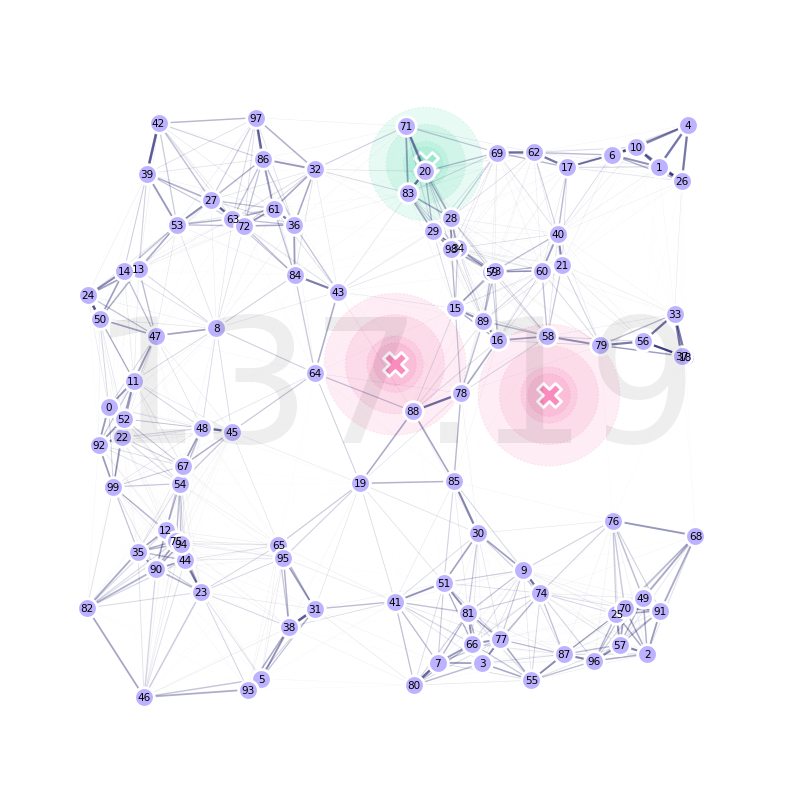

In [8]:
trpCoords = [[0, 10], [50, 0], [10, 75]]
lnd.updateTrapsCoords(trpCoords)
# Calculate the new fitness ---------------------------------------------------
fitness = srv.calcFitness(
    lnd.trapsCoords, lnd, 
    optimFunction=srv.getDaysTillTrapped,
    optimFunctionArgs={'inner': np.sum, 'outer': np.mean}
)[0]
# Plot the new location for the traps -----------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax, transparencyHex='55', size=300, zorders=(-20,-30))
srv.plotClean(fig, ax, bbox=((-125, 125), (-125, 125)))
srv.plotFitness(fig, ax, fitness)
for (ix, xy) in enumerate(lnd.pointCoords):
    ax.text(
        xy[0], xy[1], int(ix), 
        fontsize=7.5, zorder=10, ha='center', va='center_baseline'
    )

### Globe

Plotting landscapes in latitude-longitude coordinates is a bit more complicated but [MGSurvE](https://github.com/Chipdelmal/MGSurvE) tries to adhere to [cartopy](https://scitools.org.uk/cartopy/) standards, which also makes it compatible with [OSMnx](https://osmnx.readthedocs.io/). For more information on these type of applications please have a look at our [OpenStreetMap demo](../more/osm.ipynb).

![](../../media/Niangoloko.png)